# Importing training Data

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:

import omegaconf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.model import PosPredictor
from utils.tracker import Tracker
from utils.data import  Dataset
import numpy as np

In [2]:
conf = omegaconf.OmegaConf.load('configs/baseConfig.yaml')
conf.LoaderParams.ParticleNumber = 100
train_dataset = Dataset('data/train',**conf.LoaderParams)

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=conf.TrainingParams.batch_size,shuffle=True)

In [4]:
batch = next(iter(train_loader))

torch.Size([256, 100, 41, 3])

In [4]:
def SinkhornMatching(distMx,temp=0.59,n_iter=10):
    S = torch.softmax(-distMx/temp,dim=1)
    for i in range(n_iter):
        S /= torch.sum(S,dim=1,keepdim=True)
        S /= torch.sum(S,dim=2,keepdim=True)
    return S

In [5]:
rootDir = 'runs_PosPred'
exper = "Mar25_12-39-34_cluster6_lessParticleTargetLayer_0_dims_2_pnum_100"
expconf = omegaconf.OmegaConf.load(f'{rootDir}/{exper}/config.yaml')
model1 = PosPredictor(**expconf.ModelParams)
model1.load_state_dict(torch.load(f'{rootDir}/{exper}/model.pth'))
train_loader = DataLoader('data/train',**expconf.LoaderParams)

In [6]:
linparams = {
  0: {'x0':2.16319192, 'x1':-1.18323074,'x2':-1.51100711e-04}, 
  1:{'x0' : 6.89116584, 'x1':-5.91835476, 'x2': -2.05235233e-04} 
}

In [34]:
params = np.array([np.array([2.1566,-1.1769,-0.0001]),np.array([6.8254,-5.8531,-0.0002]),np.array([1.8068,-0.8102,0.0])] )

In [7]:
params0 = np.array([2.16319192,-1.18323074,-1.51100711e-04]) #p1*x1 + p2*x2 + p3
params1 = np.array([6.89116584,-5.91835476,-2.05235233e-04]) #p1*x1 + p2*x2 + p3

In [8]:
batch = next(iter(train_loader))
batch.shape

(256, 100, 41, 2)

In [ ]:
for targetLayer in range(0,10):
    target = torch.Tensor(batch[:,:,targetLayer])
    tmp = batch[:,:,targetLayer+1]
    tmp2 = batch[:,:,targetLayer+2]
    pidx = targetLayer if targetLayer < 2 else 2
    pred = tmp*params[pidx,0] + tmp2*params[pidx,1] + params[pidx,2]
    distmx = torch.cdist(torch.Tensor(pred),target)
    S = SinkhornMatching(distmx,n_iter=10)
    LikelyMatches = torch.argmax(S,dim=1)
    acc = target[torch.arange(target.shape[0]).unsqueeze(1),LikelyMatches].eq(target).sum()/target.nelement()
    print(f'PG Accrucay at layer {targetLayer} is {acc:.3f}')


PG Accrucay at layer 0 is 0.829
PG Accrucay at layer 1 is 0.728
PG Accrucay at layer 2 is 0.981
PG Accrucay at layer 3 is 0.978
PG Accrucay at layer 4 is 0.981
PG Accrucay at layer 5 is 0.981
PG Accrucay at layer 6 is 0.975
PG Accrucay at layer 7 is 0.979
PG Accrucay at layer 8 is 0.971
PG Accrucay at layer 9 is 0.974


In [31]:
acc.item()/target.nelement()

0.948984375

In [16]:
targetLayer = 0
target = batch[:,:,targetLayer]
tmp = batch[:,:,targetLayer+1]
tmp2 = batch[:,:,targetLayer+2]
pred = tmp*params0[0] + tmp2*params0[1] + params0[2]
res = target-pred



modelRes = model1(torch.Tensor(tmp[:,:,:2]),torch.Tensor(tmp2[:,:,:2]))
res2 = target- modelRes.detach().numpy()

targetLayer = 1
target = batch[:,:,targetLayer]
tmp = batch[:,:,targetLayer+1]
tmp2 = batch[:,:,targetLayer+2]
modelRes = model1(torch.Tensor(tmp[:,:,:2]),torch.Tensor(tmp2[:,:,:2]))
pred = tmp*params0[:2]
res11 = target-pred
res12 = target- modelRes.detach().numpy()

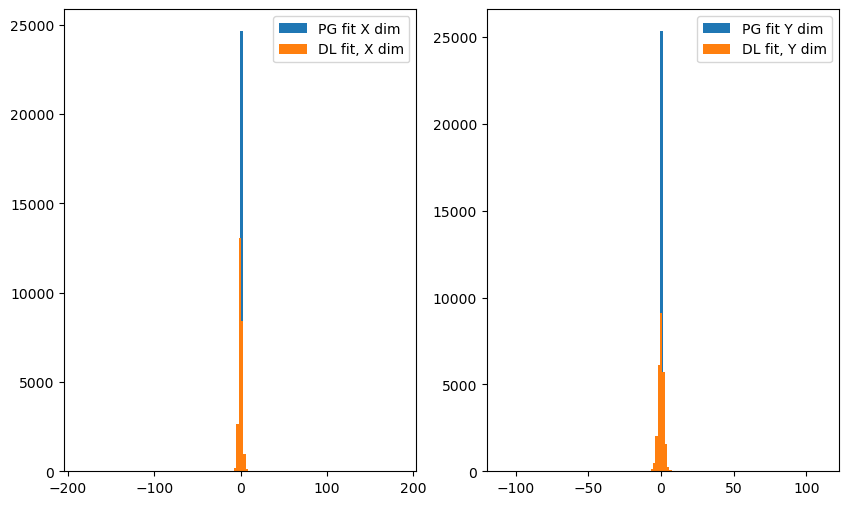

In [18]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(res[:,:,0].flatten(),bins = 100,label='PG fit X dim')
plt.hist(res2[:,:,0].flatten(),bins = 100,label = 'DL fit, X dim')
plt.legend()
plt.subplot(122)
plt.hist(res[:,:,1].flatten(),bins = 100,label='PG fit Y dim')
plt.hist(res2[:,:,1].flatten(),bins = 100,label = 'DL fit, Y dim')
plt.legend()
None

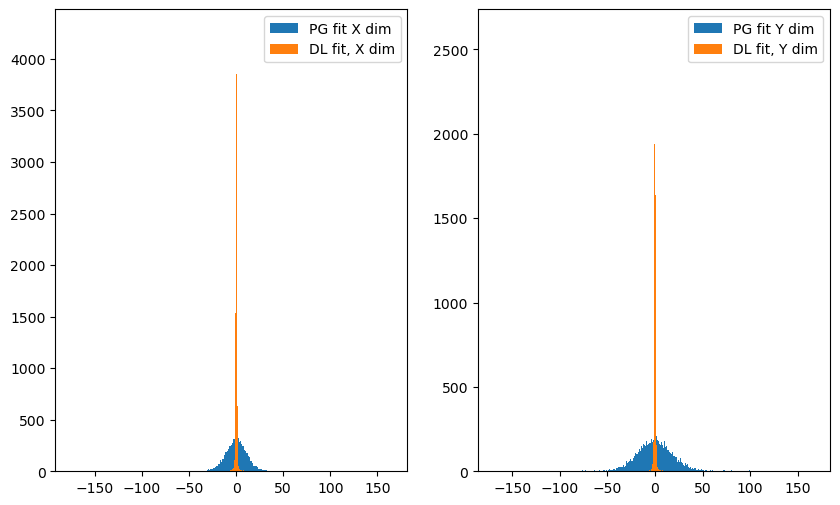

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(res11[:,:,0].flatten(),bins = 1000,label='PG fit X dim')
plt.hist(res12[:,:,0].flatten(),bins = 1000,label = 'DL fit, X dim')
plt.legend()
plt.subplot(122)
plt.hist(res11[:,:,1].flatten(),bins = 1000,label='PG fit Y dim')
plt.hist(res12[:,:,1].flatten(),bins = 1000,label = 'DL fit, Y dim')
plt.legend()
None

# Model testings

In [80]:
#rootDir = 'runs'
#exper = "Mar04_10-44-10_cluster6_vanilla_layer_0"
#expconf = omegaconf.OmegaConf.load(f'{rootDir}/{exper}/config.yaml')
#model1 = PosPredictor(**expconf.ModelParams)
#model1.load_state_dict(torch.load(f'{rootDir}/{exper}/model.pth'))
#
#exper = "Mar04_10-44-03_cluster6_vanilla_layer_1"
#expconf = omegaconf.OmegaConf.load(f'{rootDir}/{exper}/config.yaml')
#model2 = PosPredictor(**expconf.ModelParams)
#model2.load_state_dict(torch.load(f'{rootDir}/{exper}/model.pth'))

In [11]:
trakcer = Tracker(model1=None,model2=None)
valLoader = DataLoader('data/test',**conf.ValLoaderParams,ParticleNumber=200)
trakcer.add_loader(valLoader)
trakcer.temp = 0.1

In [12]:
def CorrectionMask(S,x_prev):
    ##
    ## Flag values where true has 0 values
    ## Or simply accept flags as args
    xpreds = torch.argmin(S,dim=1)
    ypreds = torch.argmin(S,dim=2)
    #x_prev[torch.arange(x_prev.size(0)).unsqueeze(1),xpreds] == 0
    zmask = x_prev == 0 #+x_prev[torch.arange(x_prev.size(0)).unsqueeze(1),ypreds] == 0
    return xpreds == ypreds + zmask.all(dim = -1)

# Try model accuracies

In [13]:
batch = torch.from_numpy(next(iter(train_loader)))
t = 20
x_target = batch[:,:,t]
x_prev = batch[:,:,t-1]

In [14]:
xl = batch[:,:,t+2]
xr = batch[:,:,t+1]
y = batch[:,:,t]

In [15]:
res, mask = trakcer.match(x_prev,x_prev)

In [16]:

for t in range(0,30):
    x_target = batch[:,:,t]
    x_prev = batch[:,:,t-1]
    distmx = torch.cdist(x_prev,x_target)
    S = SinkhornMatching(distmx,n_iter=10)
    LikelyMatches = torch.argmax(S,dim=1)
    res, _ = trakcer.match(x_prev,x_target)
    acc = x_target[torch.arange(x_target.size(0)).unsqueeze(1),LikelyMatches].eq(x_target).sum().item()/x_prev.nelement()
    acc2 = x_target[torch.arange(x_target.size(0)).unsqueeze(1),res].eq(x_target).sum().item()/x_prev.nelement()
    print(f"Accuracy at layer {t} is {acc:.3f}, {acc2:.3f}")

Accuracy at layer 0 is 0.005, 0.005
Accuracy at layer 1 is 0.452, 0.401
Accuracy at layer 2 is 0.627, 0.592
Accuracy at layer 3 is 0.954, 0.986
Accuracy at layer 4 is 0.961, 0.983
Accuracy at layer 5 is 0.951, 0.980
Accuracy at layer 6 is 0.980, 0.977
Accuracy at layer 7 is 0.981, 0.972
Accuracy at layer 8 is 0.964, 0.970
Accuracy at layer 9 is 0.965, 0.966
Accuracy at layer 10 is 0.963, 0.962
Accuracy at layer 11 is 0.962, 0.960
Accuracy at layer 12 is 0.963, 0.956
Accuracy at layer 13 is 0.936, 0.954
Accuracy at layer 14 is 0.961, 0.950
Accuracy at layer 15 is 0.954, 0.947
Accuracy at layer 16 is 0.945, 0.944
Accuracy at layer 17 is 0.924, 0.940
Accuracy at layer 18 is 0.918, 0.937
Accuracy at layer 19 is 0.922, 0.938
Accuracy at layer 20 is 0.908, 0.940
Accuracy at layer 21 is 0.911, 0.942
Accuracy at layer 22 is 0.937, 0.946
Accuracy at layer 23 is 0.942, 0.950
Accuracy at layer 24 is 0.947, 0.953
Accuracy at layer 25 is 0.939, 0.957
Accuracy at layer 26 is 0.928, 0.960
Accuracy at

In [17]:
S = torch.cdist(x_target,x_prev)
LikelyMatches = torch.argmin(S,dim=1)
xpreds = torch.argmin(S,dim=1)
ypreds = torch.argmin(S,dim=2)
mask = xpreds == ypreds

In [18]:
x_target.eq(x_target[torch.arange(x_target.size(0)).unsqueeze(1),LikelyMatches]).all(dim=-1).sum().item()/(x_target.size(0)*x_target.size(1))

0.94029296875

In [6]:
import time
import tqdm
loopObj = tqdm.tqdm(range(400),colour='blue',desc='Training')
for i in loopObj:
    time.sleep(.2)
    loopObj.set_description(f"Training {i}")
    loopObj.refresh()

Training 18:   5%|▍         | 19/400 [00:04<01:21,  4.68it/s]


KeyboardInterrupt: 

# Testing Tracker

In [74]:
batch = torch.from_numpy(next(iter(train_loader)))
tracks = torch.zeros_like(batch)
masks = torch.zeros_like(batch)
for t in range(3,30):
    x_target = batch[:,:,t]
    x_prev = batch[:,:,t+1]
    #x_prev2 = batch[:,:,t+2]
    res, mask = trakcer.step(x_target,x_prev,x_prev,t,useSinkhorn=True)
    tracks[:,:,t] = x_target[torch.arange(x_target.size(0)).unsqueeze(1),res]
    masks[:,:,t] = torch.stack([mask,mask,mask],dim=-1)
    acc, purity = trakcer.scoreMatch(x_target=x_target,res=res,mask=mask)
    print(f"Layer {t} acc: {acc:.3f} purity: {purity}")

Layer 3 acc: 0.080 purity: 0.0
Layer 4 acc: 0.090 purity: 0.0
Layer 5 acc: 0.100 purity: 0.0
Layer 6 acc: 0.108 purity: 0.0
Layer 7 acc: 0.118 purity: 0.0
Layer 8 acc: 0.129 purity: 0.0
Layer 9 acc: 0.139 purity: 0.0
Layer 10 acc: 0.147 purity: 0.0
Layer 11 acc: 0.157 purity: 0.0
Layer 12 acc: 0.166 purity: 0.0
Layer 13 acc: 0.178 purity: 0.0
Layer 14 acc: 0.186 purity: 0.0
Layer 15 acc: 0.196 purity: 0.0
Layer 16 acc: 0.205 purity: 0.0
Layer 17 acc: 0.211 purity: 0.0
Layer 18 acc: 0.212 purity: 0.0
Layer 19 acc: 0.258 purity: 0.0
Layer 20 acc: 0.314 purity: 0.0
Layer 21 acc: 0.368 purity: 0.0
Layer 22 acc: 0.418 purity: 0.0
Layer 23 acc: 0.488 purity: 0.0
Layer 24 acc: 0.530 purity: 0.0
Layer 25 acc: 0.567 purity: 0.0
Layer 26 acc: 0.612 purity: 0.0
Layer 27 acc: 0.662 purity: 0.0
Layer 28 acc: 0.710 purity: 0.0
Layer 29 acc: 0.756 purity: 0.0


In [ ]:
for i in range(10):
    batch = torch.from_numpy(next(iter(train_loader)))
    res = trakcer.tracking(batch,maxLayer=10,useSinkhorn=False)
    print(res['overall'], res['puretracks'],res['numRemaining'])

0.9569642857142857 0.9151171875 171.76953125
0.9577650669642858 0.91828125 172.69921875
0.9573409598214285 0.915859375 172.1953125
0.9565066964285714 0.915234375 171.8359375
0.9558314732142857 0.9161328125 171.30859375
0.9568666294642857 0.9147265625 172.1171875
0.9558342633928572 0.91705078125 171.15625
0.9568024553571428 0.91662109375 172.39453125
0.9565318080357142 0.9162109375 171.953125
0.9564285714285714 0.91744140625 171.6328125


In [ ]:
maxLayer = 20
target = batch[:,:,3:maxLayer]
tracks = torch.zeros_like(batch)
masks = torch.zeros_like(batch)
resDict = {}
for t in range(3,maxLayer):
    x_curr = batch[:,:,t]
    x_prev = batch[:,:,t+1]
    x_prev2 = batch[:,:,t+2]
    res,mask = step(x_curr,x_prev,x_prev2,t,useSinkhorn=True)
    tracks[:,:,t] =  x_curr[torch.arange(x_curr.size(0)).unsqueeze(1),res]
    masks[:,:,t] = torch.stack([mask,mask,mask],dim=-1)

In [14]:
for i in range(10):
    batch = torch.from_numpy(next(iter(train_loader)))
    batch = batch[:100]
    res = trakcer.tracking(batch,maxLayer=30)
    print(res['overall'], res['puretracks'],res['numRemaining'])

0.9111 0.56555 102.67
0.9082740740740741 0.5548 103.52
0.91245 0.5742 101.06
0.9087777777777778 0.53955 103.34
0.9110314814814815 0.55805 101.97
0.9096555555555556 0.56005 101.44
0.91015 0.55695 102.53
0.9123722222222223 0.5611 102.69
0.9081092592592592 0.5376 103.72
0.9091925925925926 0.54395 104.55


In [ ]:
testMask = masks[:,:,3:maxLayer]
testMask = testMask == 1
trackmatch = target == preds
allMatches = trackmatch.all(axis = 2)
outTracks = ~testMask.all(axis=2)
acc = target.eq(preds).sum().item()/target.nelement()
overall = torch.sum(allMatches+outTracks).item()/allMatches.nelement()
numPureTracks = testMask.all(axis = 2).sum()//3
numTracks = target.shape[1]*numPureTracks.item()/(target.shape[1]*target.shape[0])

In [10]:
testBatch = batch[:,:,2:20]
testTracks = tracks[:,:,2:20]
testMasks = masks[:,:,2:20]
testBatch.eq(testTracks).sum().item() /testBatch.nelement()

0.009812282986111111

In [11]:
testMasks = testMasks == 1

In [12]:
testMasks.shape, testBatch.shape

(torch.Size([256, 200, 18, 3]), torch.Size([256, 200, 18, 3]))

In [13]:
#.eq(testTracks[torch.arange(testBatch.size(0)).unsqueeze(1),testMasks]).sum().item() / testMasks.sum().item()
b = 0
tb = testBatch[b]
tt = testTracks[b]
tm = testMasks[b]


tb[tm.all(axis = -1)]

tensor([[-4.3071e+00,  2.7279e+00,  2.4459e-02],
        [-4.3612e+00,  2.6711e+00,  2.4189e-02],
        [-4.4053e+00,  2.5256e+00,  1.7284e-02],
        ...,
        [-6.1780e+00,  2.7208e+01,  8.1734e-02],
        [-6.5824e+00,  2.7407e+01,  5.0716e-02],
        [-7.1215e+00,  2.7607e+01,  5.0197e-02]])

In [14]:
testBatch[testMasks].shape

torch.Size([2572248])

In [15]:
trackmath = testBatch == testTracks
allMatches = trackmath.all(axis = 2)
outTracks = ~testMasks.all(axis = 2)
torch.sum(allMatches+outTracks).item()/allMatches.numel()

0.86369140625

In [ ]:
testMasks.all(axis = 2).sum()//3
256*200/

tensor(1.0226)

In [52]:
testBatch.shape

torch.Size([256, 200, 18, 3])

In [51]:
numPureTracks = testMasks.all(axis = 2).sum()//3
200* numPureTracks.item()/(testBatch.shape[0]*testBatch.shape[1])

65.1953125

In [30]:
testMasks.sum().item()/testBatch.nelement()

0.9262272135416667

In [ ]:
#/testMasks.nelement()
testMasks.all(axis = 2).sum().item()/testMasks

torch.Size([256, 200, 3])

In [20]:
rootDir = 'runs'
exper = "Mar05_02-41-59_cluster6_neuron_gridsearch"
expconf = omegaconf.OmegaConf.load(f'{rootDir}/{exper}/config.yaml')
model = PosPredictor(**expconf.ModelParams)
model.load_state_dict(torch.load(f'{rootDir}/{exper}/model.pth'))
model.eval()
#model = torch.load(f'{rootDir}/{exper}/model.pth')

PosPredictor(
  (left1): Linear(in_features=3, out_features=256, bias=True)
  (leftact1): ReLU()
  (left2): Linear(in_features=256, out_features=512, bias=True)
  (right1): Linear(in_features=3, out_features=256, bias=True)
  (rightact1): ReLU()
  (right2): Linear(in_features=256, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=3, bias=True)
)

In [40]:
conf.keys()

dict_keys(['LoaderParams', 'ValLoaderParams', 'ModelParams', 'TrainingParams', 'SinkhornParams', 'deviceNum'])

In [49]:
batch = torch.from_numpy(next(iter(trakcer.loader)))
targetLayer = 4
x_prev = batch[:,:,targetLayer+1]
x_curr = batch[:,:,targetLayer]
res = trakcer.match(x_prev,x_curr)


In [52]:
x_curr[0].eq(x_curr[0][res[0]].view_as(x_curr[0])).sum()/x_curr[0].nelement()

tensor(0.9800)

torch.Size([256, 100])

In [26]:
batch = torch.from_numpy(next(iter(train_loader)))

In [27]:
x2 = batch[:,:,2]
x1 = batch[:,:,1]
x0 = batch[:,:,0]

In [29]:
x_pred = model(x1,x2)

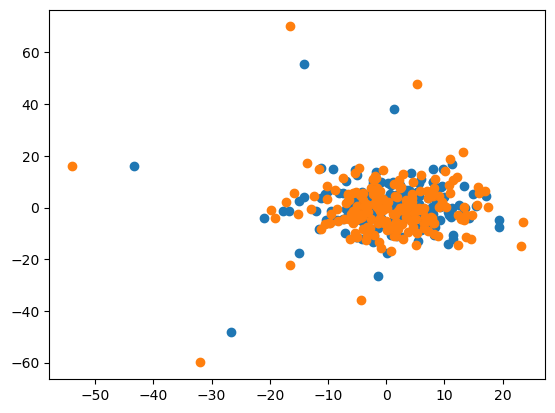

In [30]:
plt.scatter(x0[0,:,0],x0[0,:,1])
plt.scatter(x_pred[0,:,0].detach().numpy(),x_pred[0,:,1].detach().numpy())

In [31]:
likelymatches = torch.argmin(torch.cdist(x0,x_pred),dim=1)

In [21]:
def SinkhornMatching(distMx,temp=0.59,n_iter=10):
    S = torch.softmax(-distMx/temp,dim=1)
    for i in range(n_iter):
        S /= torch.sum(S,dim=1,keepdim=True)
        S /= torch.sum(S,dim=2,keepdim=True)
    return S
def CorrectionMask(S):
    xpreds = torch.argmax(S,dim=1)
    ypreds = torch.argmax(S,dim=2)
    return xpreds == ypreds


In [22]:
conf.LoaderParams.norm = False
conf.LoaderParams.ParticleNumber = 200
train_loader = DataLoader('data/train',**conf.LoaderParams)

In [23]:
batch = next(iter(train_loader))
bidx = 64
tl = 1
batch.shape

(256, 200, 41, 3)

In [24]:
x = torch.from_numpy(batch[:bidx,:,tl])
y = torch.from_numpy(batch[:bidx,:,tl+1])
y.shape

torch.Size([64, 200, 3])

In [25]:
#x [x == 0] = 1000
#y[y == 0] = 1000

In [26]:
y.nelement()

38400

In [27]:
distMx = torch.cdist(x,y)
S = SinkhornMatching(distMx,temp = 0.5)
LikelyMatches = torch.argmax(S,dim=1)
mask = CorrectionMask(S)

In [28]:
torch.sum(mask == False)

tensor(3532)

In [29]:
#LikelyMatches = torch.argmax(S,dim=1)
torch.sum(x[0,LikelyMatches[0]] == x[0])/x[0].nelement()

tensor(0.7600)

In [30]:

x[0].shape,mask[0].shape,torch.sum(mask[0])

(torch.Size([200, 3]), torch.Size([200]), tensor(154))

In [32]:
x.eq(y.view_as(x)).sum().item()/x.nelement()

0.0040625

In [222]:
acc = 0
numRec = 0
for b in range(y.shape[0]):
    numReconstructed = torch.sum(mask[b])
    numRec += numReconstructed
    truepoints = y[b][mask[b]]
    comparepoints = y[b,LikelyMatches[b]][mask[b]]
    acc += torch.sum(comparepoints == truepoints)/(3*numReconstructed)
acc /= y.shape[0]
numRec = float(numRec)/y.shape[0]
acc,numRec

(tensor(0.8394), 145.859375)

In [1]:
!jupyter notebook stop 9999

[JupyterServerStopApp] Shutting down server on 9999...
^C
Traceback (most recent call last):
  File "/home/bdudas/anaconda3/envs/pct/bin/jupyter-notebook", line 8, in <module>
    sys.exit(main())
  File "/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/jupyter_server/extension/application.py", line 623, in launch_instance
    serverapp.start()
  File "/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 3179, in start
    self.start_app()
  File "/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 3048, in start_app
    super().start()
  File "/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/jupyter_core/application.py", line 270, in start
    self.subapp.start()
  File "/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 742, in start
    self._shutdown_or_exit(port, server)
  File "/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-pac